In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pytz
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configuration aspect graphes Matplotlib
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(22, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False
)
%config InlineBackend.figure_format = 'retina'

# Import et indexation #

In [4]:
df_source = pd.read_csv("sources/1_conso_energies_raff.csv")

In [5]:
df_source.set_index('Date',inplace=True)
df_source.tail(1)

,Conso_gaz_totale_MW,Conso_elec_totale_MW,Statut,Conso_brute_totale_MW,MA_max_7j
Date,,,,,
2022-05-31 23:30:00+02:00,28528.0,45279.0,Consolidé,75231.0,51851.0


# Tendance #

In [6]:
# Focus sur la consommation electrique dans un 1er temps
y = df_source["Conso_elec_totale_MW"].copy()

### Ordre 1 : Linéaire ###

In [7]:
# ordre 1 Deterministric Process = Linéaire. 2 = Polynomial. 3 = Cube, etc...
dp = DeterministicProcess(
    index=y.index, # Récupération des dates (contenues dans l'index)
    order=1,       # Time dummy (trend) sur la période d'entraînement
    drop=True,     # Supprime des termes si ils entraînent une collinéarité
)

In [8]:
X = dp.in_sample()
X.tail()

,trend
Date,
2022-05-31 21:30:00+02:00,182588.0
2022-05-31 22:00:00+02:00,182589.0
2022-05-31 22:30:00+02:00,182590.0
2022-05-31 23:00:00+02:00,182591.0
2022-05-31 23:30:00+02:00,182592.0


In [9]:
# Pour prédiction à fin Décembre 2022 : 7 mois = 214j x 48 demi-heures = 10272 steps
X_fore = dp.out_of_sample(steps=10272)
X_fore.tail()

,trend
192860,192860.0
192861,192861.0
192862,192862.0
192863,192863.0
192864,192864.0


In [10]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [11]:
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

In [12]:
y_pred.head()

Date
2012-01-01 00:00:00+01:00    55551.417492
2012-01-01 00:30:00+01:00    55551.402077
2012-01-01 01:00:00+01:00    55551.386662
2012-01-01 01:30:00+01:00    55551.371247
2012-01-01 02:00:00+01:00    55551.355832
dtype: float64

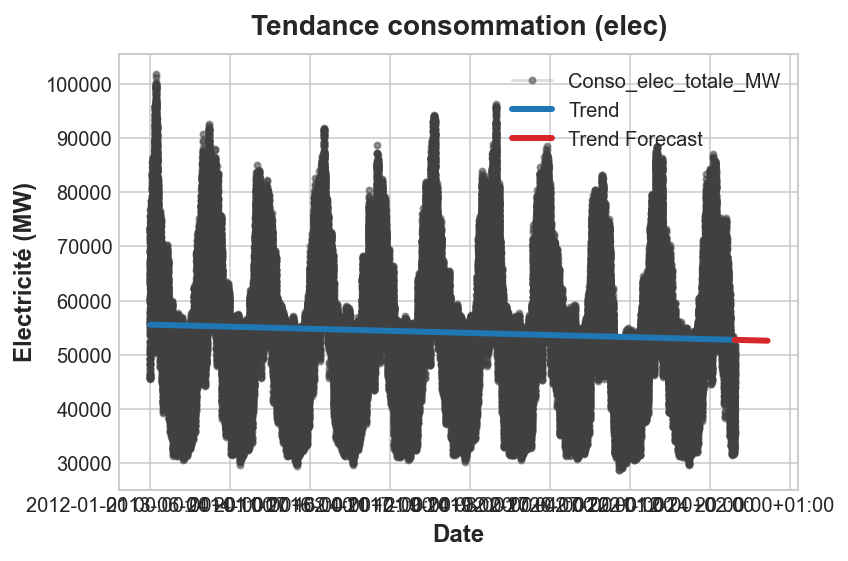

In [13]:
ax = y.plot(**plot_params, alpha=0.5, title="Tendance consommation (elec)", ylabel="Electricité (MW)")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [14]:
# The coefficients
print("Coefficients : \n", model.coef_)
# The mean squared error
print("Mean squared error : %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("R2 score : %.2f" % r2_score(y, y_pred))


Coefficients : 
 [-0.01541496]
Mean squared error : 143868792.80
R2 score : 0.00


# Sortie filtrée de la tendance #

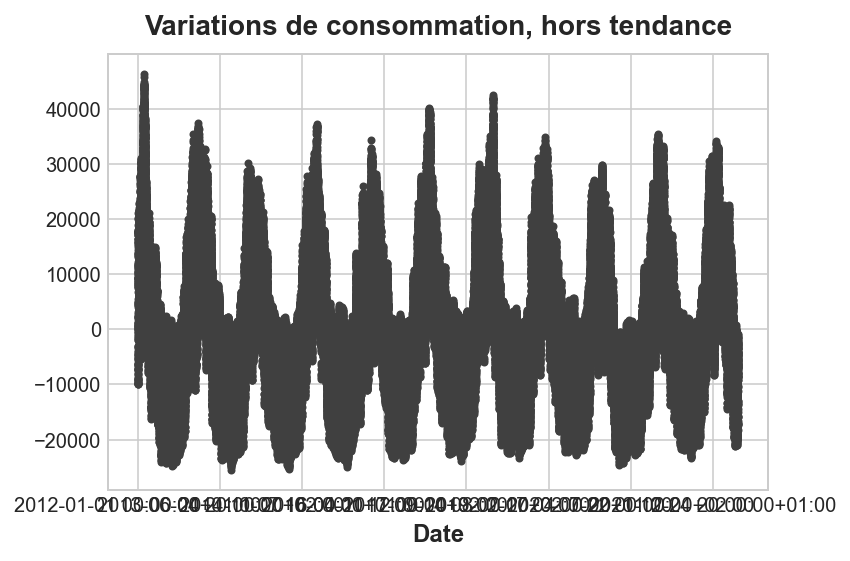

In [15]:
y_detrended = y - y_pred   # remove the trend from store_sales
y_detrended.plot(**plot_params, title="Variations de consommation, hors tendance");

In [19]:
df_elec = df_source[["Conso_elec_totale_MW"]].copy()
df_elec["conso_elec_MW_no_trend"] = y_detrended

In [20]:
df_elec.to_csv("sources/2_conso_elec_no_trend.csv", header=True, index=True)

In [21]:
df_elec.head()

,Conso_elec_totale_MW,conso_elec_MW_no_trend
Date,,
2012-01-01 00:00:00+01:00,59610.0,4058.582508
2012-01-01 00:30:00+01:00,58314.0,2762.597923
2012-01-01 01:00:00+01:00,56230.0,678.613338
2012-01-01 01:30:00+01:00,56075.0,523.628753
2012-01-01 02:00:00+01:00,55531.0,-20.355832
